In [1]:
import cptac
import scipy
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import numpy as np
import math
import pandas as pd
import statistics
import cptac.utils as ut
from functools import reduce

cptac warning: Your version of cptac (0.8.2) is out-of-date. Latest is 0.8.3. Please run 'pip install --upgrade cptac' to update it. (<ipython-input-1-b79e88b05003>, line 1)


In [2]:
def get_gene_list(tissue):
    #Returns a list of the genes that are in both proteomics and transcriptomics
    gene_list = []
    prot = tissue.get_proteomics()
    if isinstance(prot.columns, pd.MultiIndex):
        prot = prot.columns.get_level_values(0)
    trans = tissue.get_transcriptomics()
    if isinstance(trans.columns, pd.MultiIndex):
        trans = trans.columns.get_level_values(0)
    for i in prot:
        if i in trans and i not in gene_list:
            gene_list.append(i)
    return gene_list


In [3]:
def fill_genes_nan(all_genes, tissue_corr):
    tissue_genes = []
    for i, j  in tissue_corr:
        tissue_genes.append(i)
        
    for i in all_genes:
        if i not in tissue_genes:
            tissue_corr.append([i, np.nan])
    end_list = sorted(tissue_corr)
           
    return end_list

In [4]:

def correlation_list(tissue, gene_list, valid_sample_number = 30, tissue_type = "both"):
    #Returns a list of lists containing the name of the gene and the correlation
    corr_list = []
    pval_list = []
    prot = tissue.get_proteomics(tissue_type)
    if isinstance(prot.columns, pd.MultiIndex):
        prot = cptac.utils.reduce_multiindex(prot, levels_to_drop = "Database_ID")
    
    trans = tissue.get_transcriptomics(tissue_type)
    if isinstance(trans.columns, pd.MultiIndex):
        trans = cptac.utils.reduce_multiindex(trans, levels_to_drop = "Database_ID")
        
    prot_index_values = list(prot.index.values)
    trans_index_values = list(trans.index.values)
    

    for found_index in prot_index_values:
        if found_index not in trans_index_values:
            prot = prot.drop(index=found_index)
    for found_index in trans_index_values:
        if found_index not in prot_index_values:
            trans = trans.drop(index=found_index)
        
    for gene in gene_list:
        prot_measurements = prot[gene]
        prot_count = len(prot_measurements.dropna())
        
        trans_measurements = trans[gene]
        trans_count = len(trans_measurements.dropna())
        
        if prot_count < valid_sample_number or trans_count < valid_sample_number:
            continue
            
        nan_indices = set()
        prot_indices = list(prot_measurements.index.values)
        trans_indices = list(trans_measurements.index.values)
        
        #Here we are only currently taking the first column of multi_indices
        if isinstance(prot_measurements, pd.core.frame.DataFrame): 
            prot_measurements = prot_measurements.iloc[:,0]
        if isinstance(trans_measurements, pd.core.frame.DataFrame):
            trans_measurements = trans_measurements.iloc[:,0]
        for i in range(len(prot_measurements)):
            if math.isnan(prot_measurements[i]):
                nan_indices.add(prot_indices[i])
                
        for i in range(len(trans_measurements)):
            if math.isnan(trans_measurements[i]):
                nan_indices.add(trans_indices[i])
        
        nan_indices = list(nan_indices)
        prot_measurements = prot_measurements.drop(nan_indices)
        trans_measurements = trans_measurements.drop(nan_indices)
        
        correlation,pval = scipy.stats.pearsonr(prot_measurements, trans_measurements)
        if math.isnan(correlation):
            continue
        corr_list.append([gene,correlation])
        pval_list.append([gene, pval])
    return corr_list, pval_list

In [5]:
def ret_list(li):
    #Returns a list of correlations from all genes
    ret_li = []
    for i in li:
        ret_li.append(i[1])   
    return ret_li

In [6]:
def intersection(lst1, lst2): 
    return set(lst1).intersection(lst2) 

In [7]:
cptac.download("brca")
cptac.download("ccrcc")
cptac.download("colon")
cptac.download("endometrial")
cptac.download("gbm")
cptac.download("luad")
cptac.download("ovarian")
cptac.download("hnscc")
cptac.download("lscc")

brca = cptac.Brca()
ccrcc = cptac.Ccrcc()
colon = cptac.Colon()
en = cptac.Endometrial()
gbm = cptac.Gbm()
luad = cptac.Luad()
ovarian = cptac.Ovarian()
hnscc  = cptac.Hnscc()
lscc = cptac.Lscc()

cptac warning: The GBM dataset is under publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (<ipython-input-7-00c37755498a>, line 15)


cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (<ipython-input-7-00c37755498a>, line 18)


cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (<ipython-input-7-00c37755498a>, line 19)


In [8]:
brca_gene_list = get_gene_list(brca)
ccrcc_gene_list = get_gene_list(ccrcc)
colon_gene_list = get_gene_list(colon)
gbm_gene_list = get_gene_list(gbm)
luad_gene_list = get_gene_list(luad)
ovarian_gene_list = get_gene_list(ovarian)
en_gene_list = get_gene_list(en)
hnscc_gene_list = get_gene_list(hnscc)
lscc_gene_list = get_gene_list(lscc)

In [9]:
brca_corr, brca_pval = correlation_list(brca, brca_gene_list, tissue_type = "tumor")
ccrcc_corr, ccrcc_pval = correlation_list(ccrcc, ccrcc_gene_list, tissue_type = "tumor")
colon_corr, colon_pval = correlation_list(colon, colon_gene_list, tissue_type = "tumor")
en_corr, en_pval = correlation_list(en, en_gene_list, tissue_type = "tumor")
gbm_corr, gbm_pval = correlation_list(gbm, gbm_gene_list, tissue_type = "tumor")
luad_corr, luad_pval = correlation_list(luad,luad_gene_list, tissue_type = "tumor")
ovarian_corr, ovarian_pval = correlation_list(ovarian, ovarian_gene_list, tissue_type = "tumor")
hnscc_corr, hnscc_pval = correlation_list(hnscc, hnscc_gene_list, tissue_type = "tumor")
lscc_corr, lscc_pval = correlation_list(lscc, lscc_gene_list, tissue_type = "tumor")

cptac warning: Due to dropping the specified levels, dataframe now has 655 duplicated column headers. (<ipython-input-4-de1769f68afd>, line 7)
cptac warning: Due to dropping the specified levels, dataframe now has 907 duplicated column headers. (<ipython-input-4-de1769f68afd>, line 7)
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
cptac warning: Due to dropping the specified levels, dataframe now has 2495 duplicated column headers. (<ipython-input-4-de1769f68afd>, line 11)
cptac warning: Due to dropping the specified levels, dataframe now has 745 duplicated column headers. (<ipython-input-4-de1769f68afd>, line 7)
cptac warning: Due to dropping the specified levels, dataframe now has 1162 duplicated column headers. (<ipython-input-4-de1769f68afd>, line 7)
cptac warning: Due to dropping the specified levels, dataframe 

In [10]:
normal_brca_corr, normal_brca_pval = correlation_list(brca, brca_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_ccrcc_corr, normal_ccrcc_pval = correlation_list(ccrcc, ccrcc_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_colon_corr, normal_colon_pval = correlation_list(colon, colon_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_en_corr, normal_en_pval = correlation_list(en, en_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_gbm_corr, normal_gbm_pval = correlation_list(gbm, gbm_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_luad_corr, normal_luad_pval = correlation_list(luad,luad_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_ovarian_corr, normal_ovarian_pval = correlation_list(ovarian, ovarian_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_hnscc_corr, normal_hnscc_pval = correlation_list(hnscc, hnscc_gene_list,valid_sample_number = 7, tissue_type="normal")
normal_lscc_corr, normal_lscc_pval = correlation_list(lscc, lscc_gene_list,valid_sample_number = 7, tissue_type="normal")

cptac warning: Due to dropping the specified levels, dataframe now has 655 duplicated column headers. (<ipython-input-4-de1769f68afd>, line 7)
cptac warning: Due to dropping the specified levels, dataframe now has 907 duplicated column headers. (<ipython-input-4-de1769f68afd>, line 7)
cptac warning: Due to dropping the specified levels, dataframe now has 2495 duplicated column headers. (<ipython-input-4-de1769f68afd>, line 11)
cptac warning: Due to dropping the specified levels, dataframe now has 745 duplicated column headers. (<ipython-input-4-de1769f68afd>, line 7)
cptac warning: Due to dropping the specified levels, dataframe now has 1162 duplicated column headers. (<ipython-input-4-de1769f68afd>, line 7)
cptac warning: Due to dropping the specified levels, dataframe now has 858 duplicated column headers. (<ipython-input-4-de1769f68afd>, line 7)


In [11]:
common_genes_45 = ['AGT', 'LMOD1', 'SEPT6', 'PRPF31', 'FABP4', 'EIF3M', 'NFYC', 'NPRL2', 'APOC2', 
             'TNFAIP8L2', 'PARVA', 'SFRP1', 'INTS12', 'CD99L2', 'DHRS1', 'ABCA8', 'PGM5', 
             'JUP', 'PTN', 'INIP', 'TMEM201', 'GSTM1', 'CRTAC1', 'EMC3', 'MFAP5', 'ALDH1A2', 
             'POTEJ', 'BAD', 'EFEMP1', 'HACE1', 'ILK', 'GSTT2B', 'DBN1', 'ADK', 'FES', 'GNG2',
             'MED18', 'SHBG', 'HLA-DQB1', 'TUB', 'ADIRF', 'HMGN2', 'CGNL1', 'CAPN2', 'CTCF', 
             'DEFA4', 'TIMM8B', 'MRC1', 'NCAM1', 'ERAP2', 'GSTM3', 'CPNE1', 'TXNDC5', 'HMGN4',
             'CEP95', 'WDR45', 'FCN3', 'PTGR2', 'PAPSS1', 'APOF', 'MMAB', 'MYL9', 'NDUFA11', 
             'CXXC1', 'CCDC80', 'RBX1', 'LSM2', 'ACAP1', 'CD2', 'TNKS2', 'TMEM41B', 'STXBP6', 
             'CAP2', 'TSEN54', 'ANAPC2', 'ARHGAP30', 'EEF1A1', 'VWA5A', 'DYNLT1', 'RSAD1', 
             'F13A1', 'RBP7', 'FSTL1', 'PHGDH', 'SH3BP1', 'ITGAM', 'BRMS1', 'MAGED2', 'PTGDS', 
             'GNA11', 'MOXD1', 'RPS27A', 'DENND4B', 'MRPS18C', 'TAB1', 'CCL14', 'RPS8', 'DNM1',
             'RAB23', 'KYAT1', 'FBXL3', 'RERG', 'CEP120', 'ANAPC16', 'VPS29', 'RASL12', 'JPH2',
             'SPARC', 'SNX4', 'ASCC1', 'MINDY2', 'LUM', 'CDK9', 'UQCR11', 'MVB12B', 'ARPC4',
             'RABGGTA', 'COL14A1', 'MICAL1', 'PSEN1', 'SNAPC3', 'LRRC25', 'SPECC1L', 'ABHD12', 
             'CD5', 'MATN2', 'HGF', 'SNTA1', 'PODN', 'FRZB', 'COA6', 'SPEG', 'U2AF1', 'GBP3', 
             'ADAMTSL3', 'POSTN', 'RPS27L', 'PLA2G4C', 'DCTN5', 'MYOF', 'RPN2', 'WDR7', 'FIBP',
             'RPS21', 'ELMO2', 'NEXN', 'FCER1G', 'MAOB', 'MLEC', 'RBM7', 'NAE1', 'SNRK', 'RPS16',
             'FGD5', 'MZB1', 'OGFOD3', 'WWOX', 'MED14', 'SERPINF2', 'HCLS1', 'SLC25A46', 'TRAPPC12',
             'GRN', 'PXDN', 'PRUNE2', 'SCP2', 'C1QC', 'EIF3C', 'FHL5', 'TJP1', 'GPD1L', 'EIF3E',
             'STRADA', 'CYP1B1', 'F11', 'ADIPOQ', 'PDLIM7', 'SORBS1', 'LIMD2', 'ZHX3', 'CRACR2B',
             'UBALD1', 'SKIV2L', 'HSD17B11', 'ALDH1L2', 'E4F1', 'RPF2', 'PRAM1', 'MYO9A', 'FCGR2B',
             'MAPK8IP3', 'WASHC2C', 'CDA', 'PHACTR4', 'ABLIM3', 'COMP', 'CD209', 'CCL21', 'ADD1',
             'SETD7', 'TGFBR1', 'IGFBP6', 'DSTYK', 'NCLN', 'RBFA', 'CD163L1', 'TAF10', 'SSH2', 'MGLL',
             'DDX3Y', 'SELP', 'LAIR1', 'KXD1', 'ANAPC11', 'CIB1', 'RPL22', 'TYROBP', 'NQO2', 'GGA2',
             'LCP1', 'RPS4Y1', 'TTN', 'PTPRC', 'NT5C3B', 'EIF1AY', 'ALDH1A1', 'DPYSL3', 'GSTA1', 'ALOX5',
             'PGLYRP2', 'GSTM5', 'RTN1', 'SIDT2', 'ITIH1', 'MOSPD2', 'MSR1', 'DBH', 'BORCS8', 'MCL1',
             'SPN', 'CSF1R', 'PCCB', 'EVPL', 'ATP6V1C1', 'SAA1', 'XIRP2', 'C18orf21', 'C11orf98',
             'LAGE3', 'RAB3IL1', 'TIMM29', 'MYO5C', 'VPS18', 'RABL2B', 'USP53', 'DOCK2', 'DOK2', 
             'CCNC', 'ASPA', 'AIF1', 'LGALS9', 'MCAM', 'ADGRV1', 'CSTB', 'CASP7', 'ERAP1', 'UBXN2A',
             'NCF1', 'FMO1', 'SH3BGRL3', 'PSMB4', 'TNFAIP8L1', 'CORO1A', 'CORO2A', 'APBB1IP', 'PF4', 
             'APOBR', 'C8A', 'ZAP70', 'COL15A1', 'GUCY1A2', 'COTL1', 'TF', 'CCDC115', 'TMEM199',
             'GRAP2', 'HUS1', 'ICAM3', 'C8G', 'ACAD11', 'INHBC', 'IL33', 'STARD13', 'PFN1', 'CNRIP1', 
             'FERMT3', 'CTSH', 'RAPGEF3', 'GTF2A2', 'NCKAP1L', 'PROC', 'COMMD8', 'PTPN6', 'VAV1', 'CD48',
             'CYBB', 'HVCN1', 'SGCE', 'COMMD10', 'RASAL3', 'CCDC61', 'CYBA', 'LILRB5', 'HPGDS', 'F2',
             'THUMPD2', 'C12orf4', 'RRAGD', 'GANAB', 'DHDDS', 'ARHGAP6', 'FOS', 'IRF8', 'MYO1F', 'ATP9B', 
             'EBF1', 'TGFBR3', 'LSAMP', 'FABP5', 'PKD2', 'SELENOP', 'ARHGEF37', 'MLST8', 'RFESD', 'TGM2',
             'BLOC1S4', 'BBS5', 'ITGA1', 'COMMD9', 'SYNC', 'MYO9B', 'COMMD6', 'RNF7', 'POLR2E', 'ENAH',
             'AOC3', 'ARL8B', 'MSL3', 'MAPK3', 'NAA38', 'MAPT', 'RILPL1', 'LTA4H', 'FOLR2', 'LPA', 'MANF',
             'IFT52', 'CDK2AP1', 'HMBOX1', 'INO80D', 'KLHL42', 'ANXA9', 'GZMK', 'DCXR', 'MMRN1', 'GAA', 
             'MMRN2', 'NEBL', 'KRT2', 'PTGIS', 'DCLK1', 'CES1', 'CFH', 'VTN', 'NUDT2', 'ITGA7']

In [12]:
common_genes_56 = ['EMC3', 'NDUFA11', 'PHGDH', 'DEFA4', 'ILK', 'MYL9', 'SEPT6', 'TSEN54',
             'PARVA', 'ADIRF', 'NFYC', 'CRTAC1', 'GSTM1', 'EFEMP1', 'MMAB', 'WDR45',
             'ASCC1', 'MAGED2', 'RPS8', 'RASL12', 'FBXL3', 'RPS21', 'CDK9', 'DENND4B', 
             'COL14A1', 'SNX4', 'MED14', 'EIF3E', 'ADIPOQ', 'E4F1', 'ABLIM3', 'INTS12',
             'CD2', 'SFRP1', 'NPRL2', 'DBN1', 'TXNDC5', 'MRC1', 'TNKS2', 'ACAP1', 'MFAP5',
             'CAP2', 'LMOD1', 'CGNL1', 'PAPSS1', 'PRPF31', 'ARHGAP30', 'APOC2', 'CCDC80',
             'RBP7', 'FABP4', 'GSTT2B', 'TMEM41B', 'CTCF', 'FSTL1', 'LSM2', 'PTN', 'F13A1',
             'SH3BP1', 'FES', 'VWA5A', 'DHRS1', 'CXXC1', 'GNG2', 'COMMD8', 'GANAB', 'C18orf21',
             'DDX3Y', 'EIF1AY', 'HUS1', 'SSH2', 'CSTB', 'RAB3IL1', 'RPS4Y1', 'PGLYRP2',
             'ASPA', 'LGALS9', 'TYROBP', 'C11orf98', 'RPL22', 'RABL2B', 'IL33', 'MCL1', 
             'PCCB', 'GSTM5', 'RASAL3', 'HMBOX1', 'ITGA1', 'RILPL1', 'ARL8B', 'FOLR2', 
             'RFESD', 'MYO9B', 'COMMD9']

In [13]:
def get_greatest_subs_corr(gene_list, tissue_corr, normal_tissue_corr):
    tumor_corr = []
    normal_corr = []
    corr_substracted = []
    key_corr = []
    end_corr = []
    keys = sorted(dict(tissue_corr).keys())
    normal_keys = sorted(dict(normal_tissue_corr).keys())
    keys = intersection(keys, normal_keys)
    for i in gene_list:
        if i in keys:
            tumor_corr.append(dict(tissue_corr)[i])
            key_corr.append(i)
        if i in keys:
            normal_corr.append(dict(normal_tissue_corr)[i])
    
    for i in range(len(tumor_corr)):
        corr_substracted.append(tumor_corr[i] - normal_corr[i])
    sns.distplot(corr_substracted)
    plt.show()
    sigmaP = statistics.mean(corr_substracted) + 2 * np.std(corr_substracted)
    sigmaM = statistics.mean(corr_substracted) - 2 * np.std(corr_substracted)

    for i,j in enumerate(corr_substracted):
        if j > sigmaP or j < sigmaM:
            end_corr.append([key_corr[i], j])
            print (str(key_corr[i]) +': '+ str(j))
    return end_corr

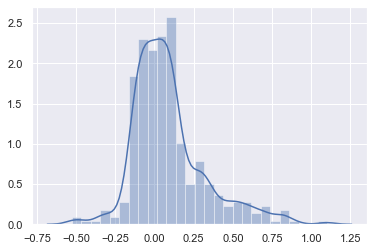

DSTYK: 1.101193235925959
MGLL: 0.8055582868614991
DDX3Y: 0.5941199999389024
GGA2: 0.8970503008601134
GSTA1: 0.6296825083854748
ITIH1: -0.5262416963147366
MOSPD2: 0.7170539249743648
MCL1: 0.5923295009897993
EVPL: 0.6464844859513015
SAA1: 0.709905950422435
LAGE3: 0.6180660378115879
MYO5C: 0.5652412485176975
RABL2B: 0.6926958153739765
ASPA: -0.45797722584584155
CASP7: 0.8057355888407919
ERAP1: 0.8347066010286059
CORO2A: 0.8317262809715882
ICAM3: 0.5790586905304758
PROC: -0.5016492797439163
PTPN6: 0.5881892949350565
VAV1: 0.634791651252105
COMMD10: 0.6947137939637396
CYBA: 0.7931368737025309
ATP9B: 0.7065459874170384


In [14]:
subs_corr = get_greatest_subs_corr(common_genes_45, en_corr,normal_en_corr)